# **RM Project**
to download SPX data use [this link](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1420070400&period2=1462060800&interval=1d&filter=history&frequency=1d)

to download LIBOR data use [this link](https://www.macrotrends.net/1433/historical-libor-rates-chart)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set_style("white")
import altair as alt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
alt.data_transformers.enable('default', max_rows=None) 

DataTransformerRegistry.enable('default')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

parent_path = r'gdrive/My Drive/RM_Project/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
os.listdir(parent_path)

['OptionPrices_2015_m1_m6.csv',
 'OptionPrices_2015_m7_m12.csv',
 'OptionPrices_2016.csv',
 'SP500_20150101-20160501.csv',
 'historical-libor-rates-chart.csv']

In [0]:
# import sys

# local_vars = list(locals().items())
# for var, obj in local_vars:
#     print(var, sys.getsizeof(obj))
#     print(var)

In [0]:
def _convert_to_datetime(df):
  df.date = pd.to_datetime(df.date.astype('Int64').astype(str), format='%Y-%m-%d').dt.date
  df.exdate = pd.to_datetime(df.exdate.astype('Int64').astype(str), format='%Y-%m-%d').dt.date
  # df.last_date = pd.to_datetime(df.astype('Int64').last_date.astype(str), format='%Y-%m-%d')
  return df

def _read_spx(files, path):
  '''
  Read from file with S&P Index data
  '''
  for file in files:
    if file == 'SP500_20150101-20160501.csv':
      dtypes = {'Date': 'str', 'Open' : 'float64', 'High': 'float64', 
                'Low': 'float64', 'Close': 'float64', 'Adj Close': 'float64', 'Volume' : 'int64'}
      headers = ['date', 'sp_open', 'sp_high', 'sp_low', 'sp_close', 'sp_adj_close', 'sp_volume']
      df = pd.read_csv(os.path.join(path, file), dtype=dtypes, names=headers, skiprows=1)
      df.date = df.date.str.replace('-', '').astype(np.int64)
  return df

def _read_options(files, path):
  '''
  Read from files with SPX options data
  '''
  headers = pd.read_csv(os.path.join(path, 'OptionPrices_2016.csv'), nrows=1).columns
  df = pd.DataFrame(columns=headers)

  for file in files:
    if file not in (['SP500_20150101-20160501.csv', 'historical-libor-rates-chart.csv']):
      df = df.append(pd.read_csv(os.path.join(path, file)))
  df.date = df.date.astype(np.int64)
  return df

def _read_libor(files, path):
  '''
  Read from file with LIBOR data
  '''
  for file in files:
    if file == 'historical-libor-rates-chart.csv':
      dtypes = {'date': 'str', '1m' : 'float64', '3m': 'float64', 
                  '6m': 'float64', '12m': 'float64'}
      headers = ['date', 'libor_1m', 'libor_3m', 'libor_6m', 'libor_12m']
      df = pd.read_csv(os.path.join(path, file), dtype=dtypes, names=headers, skiprows=1)
      df.date = pd.to_datetime(df.date.astype(str), format='%m/%d/%Y').dt.date.astype('str')
      df.date = df.date.str.replace('-', '').astype(np.int64)   
  return df

def read_files(path):
  '''
  Read SPX, options, LIBOR files and merge them into one dataframe
  '''
  files = os.listdir(path)
  df = _read_options(files, path)
  df_sp = _read_spx(files, path)
  df_libor = _read_libor(files, path)

  df = pd.merge(df, df_sp, on='date', how='left')
  # df = pd.merge(df, df_libor, on='date', how='left')
  df['year-month'] = df.date.apply(lambda x: str(x)[:6])
  df_libor['year-month'] = df_libor.date.apply(lambda x: str(x)[:6])
  df_libor.drop('date', axis=1, inplace=True)
  df = pd.merge(df, df_libor, on='year-month', how='left')
  df = _convert_to_datetime(df)
  df.strike_price /= 1000
  return df



# 1. Data Exploration / Visualization

In [7]:
df_options = read_files(parent_path)

df_options.columns

Index(['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'ss_flag', 'root', 'suffix', 'cusip', 'ticker',
       'sic', 'index_flag', 'exchange_d', 'class', 'issue_type',
       'industry_group', 'issuer', 'div_convention', 'exercise_style',
       'am_set_flag', 'sp_open', 'sp_high', 'sp_low', 'sp_close',
       'sp_adj_close', 'sp_volume', 'year-month', 'libor_1m', 'libor_3m',
       'libor_6m', 'libor_12m'],
      dtype='object')

count    39022.000000
mean        66.517477
std         51.736476
min          1.000000
25%         43.000000
50%         63.000000
75%         74.000000
max        334.000000
Name: symbol, dtype: float64

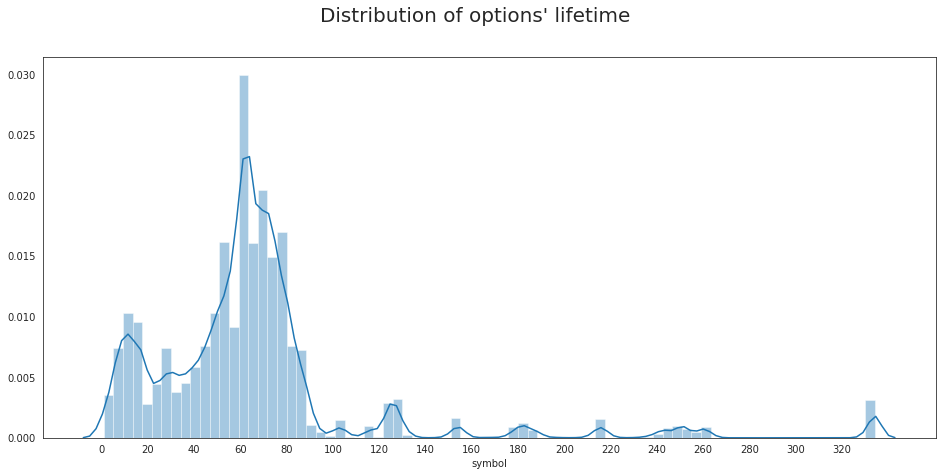

In [8]:
# by calculating the amount of each option occurs in a dataset we calculate 
# how many days each option lived. Then we can see a distributin of the 
# options' lifetime (before the preprocessing step)
optionid_distrib = df_options.groupby('optionid').count().symbol

plt.figure(figsize=(16,7))
sns.distplot(optionid_distrib, bins=80)
plt.suptitle('Distribution of options\' lifetime', fontsize=20)

xmarks=[i for i in range(0,optionid_distrib.max()+1,20)]
plt.xticks(xmarks)
optionid_distrib.describe()

Text(0.5, 0.98, 'S&P 500 Index price')

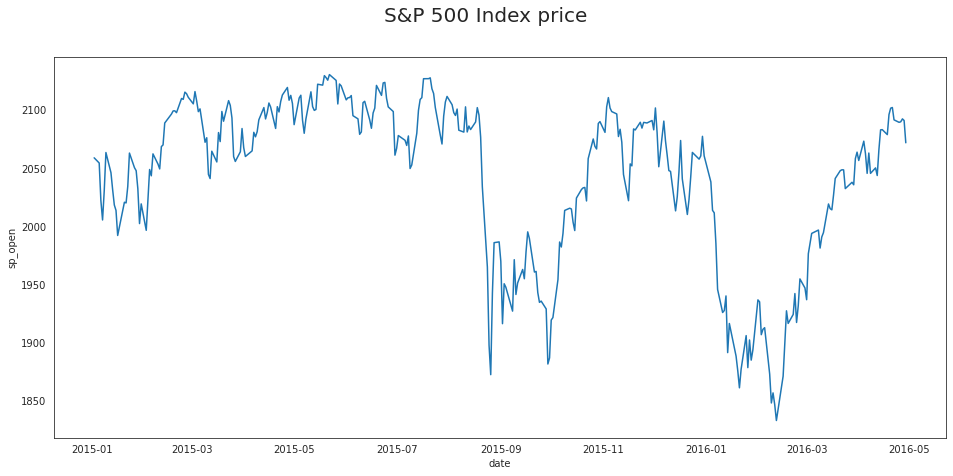

In [9]:
sp_price = df_options.drop_duplicates(['date'])[['date','sp_open']]
plt.figure(figsize=(16,7))
sns.lineplot(x='date', y='sp_open', data=sp_price)
plt.suptitle('S&P 500 Index price', fontsize=20)

Text(0.5, 0.98, 'Strike Price distribution')

<Figure size 720x360 with 0 Axes>

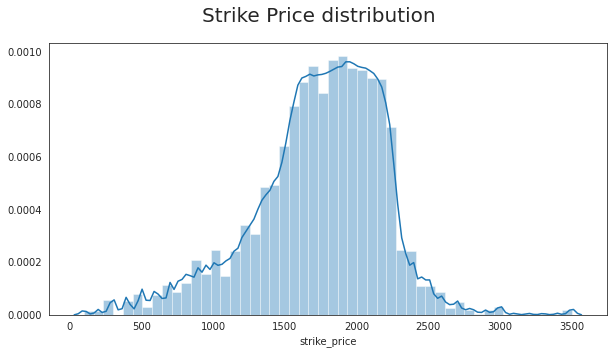

In [10]:
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
sns.distplot(df_options.strike_price)
plt.suptitle('Strike Price distribution', fontsize=20)

Text(0.5, 0.98, 'Open/Close of SPX')

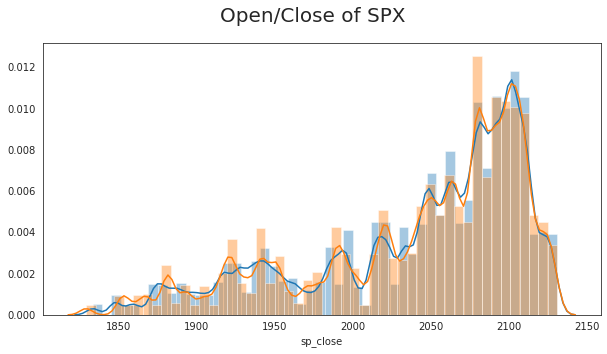

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(df_options.sp_open)
sns.distplot(df_options.sp_close)
plt.suptitle('Open/Close of SPX', fontsize=20)

## Feature selection

First, let's explain here some features that will be used in our analysis.

1. The **delta** of an option is defined as the rate of change of the option price with respect to the price of the underlying asset. Suppose that the delta of a call option on a stock is 0.6. This means that when the stock price changes by a small amount, the option price changes by about 60% of that amount.

2. The **theta** of a portfolio of options is the rate of change of the value of the portfolio with respect to the passage of time with all else remaining the same.

3. The **gamma** of a portfolio of options on an underlying asset is the rate of change of the portfolio’s delta with respect to the price of the underlying asset. It is the second partial derivative of the portfolio with respect to asset price.

4. The **vega** of a portfolio of derivatives, is the rate of change of the value of the portfolio with respect to the volatility of the underlying asset.

5. **time-to-maturity** - ...

6. **moneyness** - ...

In [0]:
def calculate_metrics(df):
  '''
  Calculate time-to-maturity, moneyness, returns of options
  '''
  df = _calculate_ttm(df)
  df = _calculate_mness(df)
  df = _calculate_returns(df)
  return df

def _calculate_ttm(df):
  '''
  Calculate time-to-maturity of options
  '''
  df['ttm'] = (df.exdate-df.date).dt.days
  return df

def _calculate_mness(df):
  '''
  Calculate moneyness of options
  '''
  df['mness'] = np.log((df.strike_price/df.sp_close).astype('float64')) / \
  (df.impl_volatility * np.sqrt(df.ttm))
  return df

def _calculate_returns(df):
  '''
  Calculate returns of options
  '''
  partial_df = df[['optionid','date', 'best_bid', 'sp_close', 'libor_12m']].sort_values(['optionid','date'])
  partial_df['optionid_shifted'] = partial_df.optionid.shift(1).fillna(0)

  # shifts best_bid by 1 day
  partial_df['best_bid_shifted'] = partial_df.best_bid.shift(1).fillna(0)
  partial_df['opt_bid_delta'] = partial_df.best_bid - partial_df.best_bid_shifted

  # shifts sp_close by 1 day
  partial_df['sp_close_shifted'] = partial_df.sp_close.shift(1).fillna(0)
  partial_df['sp_close_delta'] = partial_df.sp_close - partial_df.sp_close_shifted

  # place NaN where optionid != shifted optionid by 1 day
  partial_df.loc[partial_df.optionid != partial_df.optionid_shifted, ['opt_bid_delta','sp_close_delta']] = np.NaN

  # partial_df['calendar_dates_diff'] = partial_df.date - partial_df.date.shift(1).fillna(0)

  # (option price delta) - (underlaying delta) - something. Will ask Mykola today 
  partial_df['op_returns'] = partial_df.opt_bid_delta - partial_df.sp_close_delta
                          #  - \
                          # (partial_df.calendar_dates_diff*partial_df.libor_12m)/365 * \
                          # ()

  df = pd.merge(df, partial_df[['optionid', 'date','op_returns']], on=['optionid', 'date'])

  return df


def check_duplicates(df):
  '''
  checking if there are duplicated entries for each option by grouping by 'optionid' and 'date'
  '''
  test_duplicates_df = df_options[['optionid','date', 'symbol']].groupby(['optionid','date']).agg(
  {
    'symbol': ['count']}
  ).reset_index()
  test_duplicates_df.columns = [col[0] for col in test_duplicates_df.columns]
  test_duplicates_df = test_duplicates_df.loc[test_duplicates_df.symbol != 1]
  if test_duplicates_df.shape[0] == 0:
    print("There are no duplicate options in your dataset.")
  else: 
    print(f"Found duplicate options. \nHere is a list of them: {test_duplicates_df.optionid.unique()}")

In [13]:
df_options = calculate_metrics(df_options)
round(df_options.op_returns.describe(), 2)

count    2556623.00
mean          -0.18
std           21.19
min         -141.50
25%           -6.31
50%           -0.05
75%            5.53
max          156.58
Name: op_returns, dtype: float64

In [14]:
check_duplicates(df_options)

There are no duplicate options in your dataset.


## Data Cleaning

In [0]:
# Remove observations with negative bid-prices
df_options = df_options[df_options.best_bid - df_options.best_offer <= 0]

In [0]:
# Delete those observations with missing information for contract implied 
# volatility
df_options = df_options[~df_options.impl_volatility.isnull()]

In [0]:
# Delete contracts with a zero observation for open interest, i.e. the
# number of open positions in the option contract
df_options = df_options[df_options.open_interest != 0]

Text(0.5, 0.98, 'Distribution of moneyness')

<Figure size 720x360 with 0 Axes>

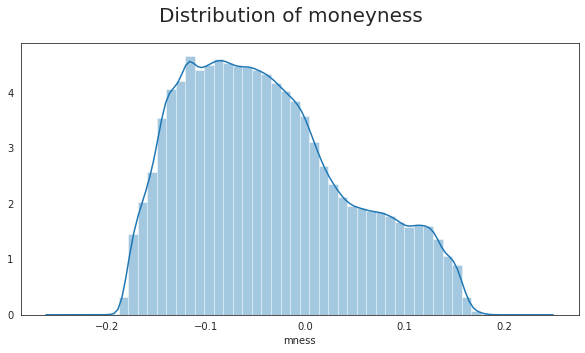

In [18]:
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
sns.distplot(df_options.mness)
plt.suptitle('Distribution of moneyness', fontsize=20)

In [0]:
# Limit the moneyness range to 0 to 2 for call options and -2.5 to 0 for
# put options
# df_options.cp_flag.unique()
df_options = df_options[
           ((df_options.cp_flag == 'C') & (df_options.mness >= 0) & (df_options.mness <= 2)) |  
           ((df_options.cp_flag == 'P') & (df_options.mness >= -2.5) & (df_options.mness <= 0))
           ]    

In [0]:
# limit the sample to options with time-to-maturity (TTM)
# between 1 month and 12 months
df_options = df_options.loc[(df_options.ttm > 31) & (df_options.ttm < 365)]

In [0]:
# Define embedded leverage
df_options['embed_lev'] = df_options.delta * df_options.sp_close / df_options.best_bid
df_options = df_options[(df_options['embed_lev'] < df_options['embed_lev'].quantile(.95)) \
                        & (df_options['embed_lev'] > df_options['embed_lev'].quantile(.05))]

In [45]:
df_options.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,ss_flag,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,sp_open,sp_high,sp_low,sp_close,sp_adj_close,sp_volume,year-month,libor_1m,libor_3m,libor_6m,libor_12m,ttm,mness,op_returns,embed_lev
595,108105,2015-01-02,SPX 150220C2060000,1,2015-02-20,20150102.0,C,2060,38.6,41.1,60,1252,0.142942,0.488878,0.003730,297.0537,-147.7123,105728781,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,201501,0.17,0.25,0.36,0.62,49,0.000874,NaN,26.067582
596,108105,2015-01-02,SPX 150220C2065000,1,2015-02-20,20150102.0,C,2065,35.6,38.1,10,982,0.140577,0.469458,0.003784,296.3324,-145.2040,106237792,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,201501,0.17,0.25,0.36,0.62,49,0.003352,NaN,27.141529
597,108105,2015-01-02,SPX 150220C2070000,1,2015-02-20,20150102.0,C,2070,32.5,35.0,206,7134,0.137537,0.449161,0.003848,294.8206,-141.5613,105888714,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,201501,0.17,0.25,0.36,0.62,49,0.005938,NaN,28.445020
598,108105,2015-01-02,SPX 150220C2075000,1,2015-02-20,20150102.0,C,2075,29.8,32.2,291,27205,0.135329,0.428692,0.003880,292.5075,-138.4739,105697034,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,201501,0.17,0.25,0.36,0.62,49,0.008582,NaN,29.608519
599,108105,2015-01-02,SPX 150220C2080000,1,2015-02-20,20150102.0,C,2080,27.1,29.5,61,8021,0.132925,0.407633,0.003907,289.2947,-134.7693,105728782,1,0,NaN,NaN,64881510,SPX,9999,1,32768,NaN,A,NaN,CBOE S&P 500 INDEX,I,E,1,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,201501,0.17,0.25,0.36,0.62,49,0.011323,NaN,30.959049
